# Retrieval-Augmented Generation: Question Answering using Pinecone, Vertex AI and Custom dataset!

### Pinecone Overview
Pinecone makes it easy to provide long-term memory for high-performance AI applications. It’s a managed, cloud-native [vector database](https://www.pinecone.io/learn/vector-database/) with a [simple API](https://docs.pinecone.io/reference) and no infrastructure hassles. Pinecone serves fresh, filtered query results with low latency at the scale of billions of vectors.

In this notebook we will demonstrate how to use Pinecone with Gemini model to answer questions using a library of documents as a reference, by using document embeddings and retrieval. The embeddings are generated using Vertex AI Text Embeddings (textembedding-gecko@003) embedding model and retrieved from [**Pinecone Vector Database**](https://www.pinecone.io/).
Access to a Pinecone environment and Google Gemini model is a prerequisite to run this notebook fully.

**You can start by using the [Free Tier on Pinecone](https://www.pinecone.io/pricing/). This notebook serves a template such that you can easily replace the example dataset by your own to build a custom question and asnwering application.**

### Gemini Overview

Gemini is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. The Gemini API gives you access to the Gemini Pro and Gemini Pro Vision models.

This notebook focuses on using the **Vertex AI SDK for Python** to call the Vertex AI Gemini API with the Gemini 1.0 Pro model.

For more information, see the [Generative AI on Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview) documentation.


### Objectives

In this tutorial, you will learn how to use the Pinecone and Gemini model to build RAG applications.

You will complete the following tasks:

#### Step 1. Install required libraries, initialize Gemini and Pinecone
#### Step 2. No-RAG response - Ask a question to LLM with out providing any Context information
#### Step 3. Provide an Ideal context and analyze the response
#### Step 4. Implement RAG approach at Scale using Pinecone

### Step 1. Install required libraries, initialize Gemini and Pinecone

In [ ]:
! git clone https://github.com/pinecone-field/live-workshop-notebooks.git
import os
os.chdir('live-workshop-notebooks/RAG_demo_Pinecone_Gemini')
! git checkout -b add-gcp-gemini-notebook
! pip install pinecone-client pinecone-notebooks pinecone-plugin-interface vertexai google-cloud-aiplatform


### Import libraries


In [ ]:
import os
import time
from tqdm.auto import tqdm
import vertexai
import pandas as pd
from pinecone import ServerlessSpec
from pinecone import Pinecone
from vertexai.generative_models import GenerativeModel
from vertexai.language_models import TextEmbeddingModel

## Authenticate the current user

Connect to Google and Pinecone and retrieve an API key.

In [ ]:
from google.colab import auth
auth.authenticate_user()

from pinecone_notebooks.colab import Authenticate

Authenticate()

### Define Google Cloud project information and initialize Vertex AI and Pinecone

Initialize the Vertex AI SDK for Python for your project:

In [ ]:
# Define project information
PROJECT_ID = ""  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
vertexai.init(project=PROJECT_ID, location=LOCATION)

# Initialize Pinecone
from pinecone import Pinecone

pc = Pinecone(api_key=os.environ['PINECONE_API_KEY'], source_tag="pinecone-notebooks:rag-gemini")

### Load the Gemini 1.0 Pro model


In [ ]:
MODEL_ID = "gemini-1.0-pro"
model = GenerativeModel(MODEL_ID)

In [ ]:
def embed_vertex(docs: list[str]) -> list[list[float]]:
    embed_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")
    embeddings = embed_model.get_embeddings(docs)
    doc_embeds = [r.values for r in embeddings]
    return doc_embeds

## Step 2. Ask a question to LLM without providing the context

To better illustrate why we need retrieval-augmented generation (RAG) based approach to solve the question and anwering problem. Let's directly ask the model a question and see how they respond.

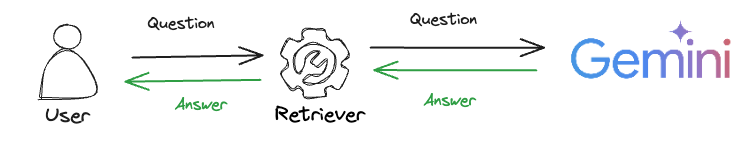

In [ ]:
question = 'What is in front of the Norte Dame Main Building?'

In [ ]:
responses = model.generate_content(question, stream=True)

for response in responses:
    print(response.text, end="")

You can see the generated answer is wrong or doesn't make much sense.

## Step 3. Improve the answer to the same question using **prompt engineering** with insightful context


To better answer the question well, we provide extra contextual information, combine it with a prompt, and send it to model together with the question. Below is an example.

In [ ]:
context = """Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary."""

In [ ]:

prompt = f"""Answer the following QUESTION based on the CONTEXT given.
 If you do not know the answer and the CONTEXT doesn't contain the answer truthfully say "I don't know".

QUESTION: {question}

CONTEXT: {context}
"""
print("Query Prompt: ", str(prompt))

In [ ]:
responses = model.generate_content(prompt, stream=True)

for response in responses:
    print(response.text, end="")

Looks great! The LLM is following instructions and we've also demonstrated how contexts can help our LLM answer questions accurately. However, we're unlikely to be inserting a context directly into a prompt like this unless we already know the answer — and if we already know the answer why would we be asking the question at all?

We need a way of extracting _relevant contexts_ from huge bases of information. For that we need **R**etrieval **A**ugmented **G**eneration (RAG).

## Step 4. Use RAG based approach to identify the correct documents, and use them along with prompt and question to query LLM


We plan to use document embeddings to fetch the most relevant documents in our document knowledge library and combine them with the prompt that we provide to LLM.

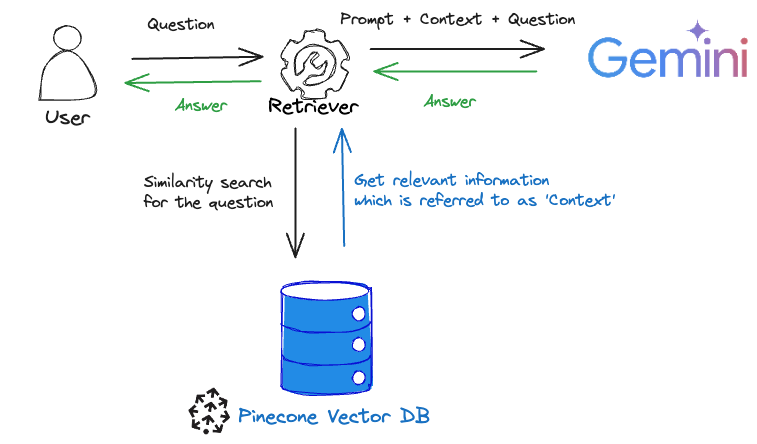

#### Step 4.1. Parse the custom dataset
#### Step 4.2. Create Pinecone Index
#### Step 4.3. Chunk the data, create embeddings and upload it into Pincone Index
#### Step 4.4. Query the data

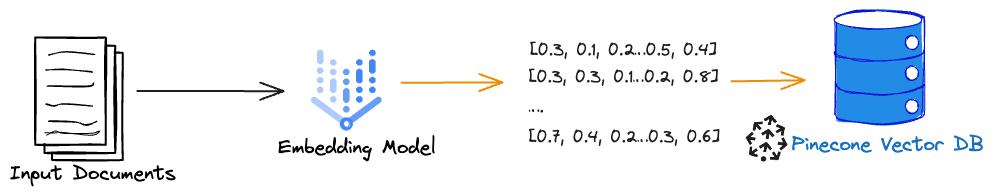

### Step 4.1 First, lets parse the custom dataset

In [ ]:
df = pd.read_parquet("data/train-00000-of-00001.parquet")
df.head()

We only care about the context in each dataframe, so we'll drop the other elements.

In [ ]:
df.drop(["id", "title", "question", "answers"], axis=1, inplace=True)
print(df.count())
df.head()

We'll also drop the duplicates.

In [ ]:
df.drop_duplicates(inplace=True)
print(df.count())
data.head()

18,000 is still a lot to work with a simple demonstration. We'll just use the first 50 entries.

In [ ]:
data = df.iloc[:50]
print(data.count())
data.head()

### Step 4.2 Create a Pinecone Index

In [ ]:
index_name = 'pinecone-gcp-rag-demo'
namespace = 'pinecone-gemini'

In [ ]:
# get existing indexes
existing_indexes = pc.list_indexes().names()

# check if index already exists (it shouldn't if this is first time)
if index_name not in existing_indexes:
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=768,  # dimensionality of textembedding-gecko@003
        metric='dotproduct',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
# view index stats
print(index.describe_index_stats())

### Step 4.3 Chunk the data, create vector embeddings and upload into Pinecone Index

In [ ]:
from tqdm.auto import tqdm

batch_size = 100  # how many embeddings we create and insert at once

for i in tqdm(range(0, len(data), batch_size)):
    passed = False
    print(i)
    # find end of batch
    i_end = min(len(data), i+batch_size)
    print(i_end)
    ids = [str(x) for x in range(i, i_end)]
    metadatas = [{"text": text} for text in data["context"][i:i_end]]
    # create embeddings
    texts = data["context"][i:i_end].tolist()
    embeds = embed_vertex(texts)
    to_upsert = list(zip(ids, embeds, metadatas))
    # upsert to Pinecone
    index.upsert(vectors=to_upsert,namespace=namespace)

We'll wait a second or so while the vectors are inserted into the index.

In [ ]:
while index.describe_index_stats().total_vector_count != len(data):
    time.sleep(1)

print(index.describe_index_stats())

### 4.4 Query the data

Now we're ready begin querying our LLM with a **R**etrieval **A**ugmented **G**eneration (RAG) pipeline. Let's see how this will work step-by-step first.

#### Step 1. Generate vector embeddings of the text query
#### Step 2. Perform Semantic Search and get relevant data to compose Context
#### Step 3. Invoke LLM with the Prompt, Context and Question

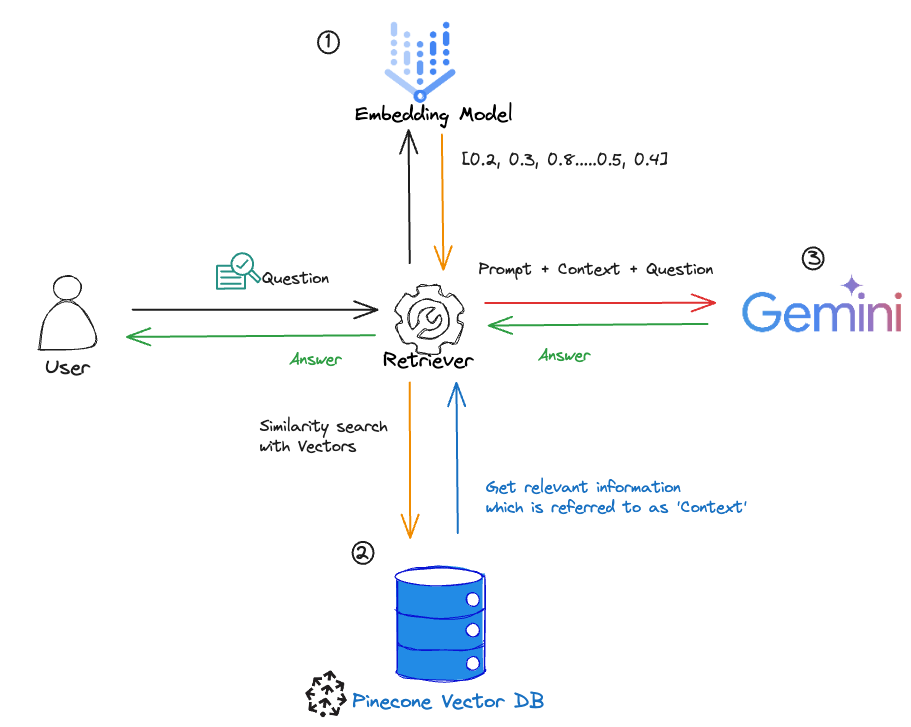

First we create our _query embedding_ and use it to query Pinecone:

### Step 4.4.1 First, create vector embeddings for the query

In [ ]:
question = 'What is in front of the Norte Dame Main Building?'
print(question)

In [ ]:
# extract embeddings for the questions
query_vec = embed_vertex([question])[0]

# query pinecone
res = index.query(vector=query_vec, top_k=5, namespace=namespace,include_metadata=True)

# show the results
res

### Step 4.4.2 Parse the Semantic Search results and contruct a single `context` to feed into our LLM prompt.

In [ ]:
contexts = [match.metadata["text"] for match in res.matches]

In [ ]:
max_section_len = 2000
separator = "\n"


def construct_context(contexts: list[str]) -> str:
    chosen_sections = []
    chosen_sections_len = 0

    for text in contexts:
        text = text.strip()
        # Add contexts until we run out of space.
        chosen_sections_len += len(text) + 2
        if chosen_sections_len > max_section_len:
            break
        chosen_sections.append(text)
    concatenated_doc = separator.join(chosen_sections)
    print(
        f"With maximum sequence length {max_section_len}, selected top {len(chosen_sections)} document sections: \n{concatenated_doc}"
    )
    return concatenated_doc

In [ ]:
context_str = construct_context(contexts=contexts)

### Step 4.4.3 Invoke the LLM with the Prompt + Context + Question

In [ ]:
prompt = f"""Answer the following QUESTION based on the CONTEXT given.
 If you do not know the answer and the CONTEXT doesn't contain the answer truthfully say "I don't know".

QUESTION: {question}

CONTEXT: {context_str}
"""
print("Query Prompt:", str(prompt))

In [ ]:
responses = model.generate_content(prompt, stream=True)

for response in responses:
    print(response.text, end="")

Now you can see the generated answer is factually accurate and comparing it to the No-RAG response how the RAG could provide real-time knowledge to the LLM and help reducing hallucination

In this notebook, we demonstrated the step-by-step creation of a comprehensive RAG pipeline using Pinecone and Google Gemini. Through this process, we illustrated effective strategies for reducing hallucination and ensuring the continuous integration of the latest data into language model knowledge. Ultimately, such enhancements aim to elevate user satisfaction and foster greater trust in our system reliability.